In [2]:
from IPython.core.display import display, HTML
from IPython import display as idisplay

import time

import pandas as pd
import numpy as np
import scipy.stats as scs
from scipy.stats import multivariate_normal as mvn
import sklearn.mixture as mix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### To gain understanding of mixture models we have to start at the beginning with the expectation maximization algorithm and it's application

### First a little history on E-M

Reference: 4

Demptser, Laird & Rubin (1977)
    -unified previously unrelated work under "The EM Algorithm"
    - unified previously unrelated work under "The EM Algorithm"
    - overlooked E-M works - see gaps between foundational authors
        - Newcomb (1887)
        - McKendrick (1926) [+39 years]
        - Hartley (1958) [+32 years]
        - Baum et. al. (1970) [+12 years]
        - Dempters et. al. (1977) [+7 years]

#### *EM Algorithm developed over 90 years*

## EM provides general framework for solving different problems

Examples include:
    - Filling in missing data from a sample set
    - Discovering values of latent variables
    - Estimating parameters of HMMs
    - Estimating parameters of finite mixtures [models]
    - Unsupervised learning of clusters
    - etc...
    
### How does the EM algorithm work? 

EM is an iterative process that begins with a "naive" or random initialization and then alternates between the expectation and maximization steps until the algorithm reaches convergence. 

To describe this in words imagine we have a simple data set consisting of class heights with groups separated by gender.

In [3]:
# import class heights

data = pd.read_csv("./Class_heights.csv")
# data.info()

height = data['Height (in)']
data

,Gender,Height (in)
0,Male,72
1,Male,72
2,Female,63
3,Female,62
4,Female,62
5,Male,73
6,Female,64
7,Female,63
8,Female,67
9,Male,71


Now imagine that we did not have the convenient gender labels associated with each data point. How could we estimate the two group means? 

First let's set up our problem. 

In this example we hypothesize that these height data points are drawn from two distributions with two means - < $\mu_1$, $\mu_2$ >.

The heights are the observed $x$ values. 

The hidden variables, which EM is going to estimate, can be thought of in the following way. Each $x$ value has 2 associated $z$ values. These $z$ values < $z_1$, $z_2$ > represent the distribution (or class or cluster) that the data point is drawn from.

Understanding the range of values the $z$ values can take is important. 

In k-means, the two $z$'s can only take the values of 0 or 1. If the $x$ value came from the first distribution (cluster), then $z_1$=1 and $z_2$=0 and vice versa. This is called **hard** clustering. 

In Gaussian Mixture Models, the $z$'s can take on any value between 0 and 1 because the x values are considered to be drawn probabilistically from 1 of the 2 distributions. For example $z$ values can be $z_1$=0.85 and $z_2$>=0.15, which represents a strong probability that the $x$ value came from distribution 1 and smaller probability that it came from distribution 2. This is called **soft** or **fuzzy** clustering. 


For this example, we will assume the x values are drawn from Gaussian distributions. 

To start the algorithm, we choose two random means. 

From there we repeat the following until convergence. 

#### The expectation step:

We calculate the expected values $E(z_{ij})$, which is the probability that $x_i$ was drawn from the $jth$ distribution.
    
$$E(z_{ij}) = \frac{p(x = x_i|\mu = \mu_j)}{\sum_{n=1}^2 p(x = x_i|\mu = \mu_j)}$$


$$= \frac{ e^{-\frac{1}{2\sigma^2}(x_i - \mu_j)^2} }
{ \sum_{n=1}^2e^{-\frac{1}{2\sigma^2}(x_i - \mu_n)^2} }$$

The formula simply states that the expected value for $z_{ij}$ is the probability $x_i$ given $\mu_j$ divided by the sum of the probabilities that $x_i$ belonged to each $\mu$

#### The maximization step:

After calculating all $E(z_{ij})$ values we can calculate (update) new $\mu$ values. 

$$ \mu_j = \frac {\sum_{i=1}^mE(z_{ij})x_i} {\sum_{i=1}^mE(z_{ij})}$$

This formula generates the maximum likelihood estimate. 

By repeating the E-step and M-step we are guaranteed to find a local maximum giving us a maximum likelihood estimation of our hypothesis. 

### What are Maximum Likelihood Estimates (MLE)

    1. Parameters describe characteristics (attributes) of a population. These parameter values are estimated from samples collected from that population.

    2. A MLE is a parameter estimate that is most consistent with the sampled data. By definition it maximizes the likelihood function. One way to accomplish this is to take the first derivative of the likelihood function w/ respect to the parameter theta and solve for 0. This value maximizes the likelihood function and is the MLE

### A quick example of a maximum likelihood estimate
    
#### You flip a coin 10 times and observe the following sequence (H, T, T, H, T, T, T, T, H, T)
#### What's the MLE of observing 3 heads in 10 trials?    

#### simple answer:    
    The frequentist MLE is (# of successes) / (# of trials) or 3/10

#### solving first derivative of binomial distribution answer:    

\begin{align}
\mathcal L(\theta) & = {10 \choose 3}\theta^3(1-\theta)^7 \\[1ex]
log\mathcal L(\theta) & = log{10 \choose 3} + 3log\theta + 7log(1 - \theta) \\[1ex]
\frac{dlog\mathcal L(\theta)}{d(\theta)} & = \frac 3\theta - \frac{7}{1-\theta} = 0 \\[1ex]
\frac 3\theta & = \frac{7}{1 - \theta} \Rightarrow \frac{3}{10}
\end{align}

#### That's a MLE! This is the estimate that is most consistent with the observed data

In [4]:
# Code sourced from:
#    http://people.duke.edu/~ccc14/sta-663/EMAlgorithm.html

def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        print('\nIteration: ', i)
        print()
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)

        # M-step
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()
        
        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        new_mus = (np.diag(mus)[0], np.diag(mus)[1])
        new_sigs = (np.unique(np.diag(sigmas[0]))[0], np.unique(np.diag(sigmas[1]))[0])
        df = (pd.DataFrame(index=[1, 2]).assign(mus = new_mus).assign(sigs = new_sigs))
        
        xx = np.linspace(0, 100, 100)
        yy = scs.multivariate_normal.pdf(xx, mean=new_mus[0], cov=new_sigs[0])
        
        colors = sns.color_palette('Dark2', 3)
        fig, ax = plt.subplots(figsize=(9, 7))
        ax.set_ylim(-0.001, np.max(yy))
        ax.plot(xx, yy, color=colors[1])
        ax.axvline(new_mus[0], ymin=0., color=colors[1])
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[1])
        lo, hi = ax.get_ylim()
        ax.annotate(r"$\mu_1$: {:7.2f}".format(new_mus[0]), 
                    fontsize=12, fontweight='demi',
                    xy=(new_mus[0], (hi-lo) / 2), 
                    xycoords='data', xytext=(80, (hi-lo) / 2),
                    arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[2])
        
        yy2 = scs.multivariate_normal.pdf(xx, mean=new_mus[1], cov=new_sigs[1])
        
        ax.plot(xx, yy2, color=colors[2])
        ax.axvline(new_mus[1], ymin=0., color=colors[2])
        lo, hi = ax.get_ylim()
        ax.annotate(r"$\mu_2$: {:7.2f}".format(new_mus[1]),
                    fontsize=12, fontweight='demi',
            xy=(new_mus[1], (hi-lo) / 2), xycoords='data', xytext=(25, (hi-lo) / 2),
            arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy2, alpha=0.5, color=colors[2])
        
        dot_kwds = dict(markerfacecolor='white', markeredgecolor='black', markeredgewidth=1, markersize=10)
        ax.plot(height, len(height)*[0], 'o', **dot_kwds)
        ax.set_ylim(-0.001, np.max(yy2))
        
        
        print(df.T)   
        
        # update complete log likelihoood
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)
        print('log_likelihood: {:7.4f}'.format(ll_new))
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
        
    return ll_new, pis, mus, sigmas


Iteration:  0

               1           2
mus    61.362928   59.659685
sigs  469.240750  244.382352
log_likelihood: -141.8092

Iteration:  1

              1          2
mus    68.73773  63.620554
sigs  109.85442   7.228183
log_likelihood: -118.0520

Iteration:  2

              1          2
mus   70.569842  63.688825
sigs   4.424452   3.139277
log_likelihood: -100.2591

Iteration:  3

              1          2
mus   70.569842  63.688825
sigs   4.424427   3.139278
log_likelihood: -100.2591


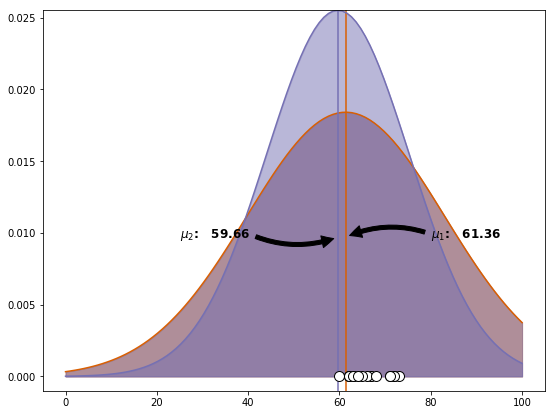

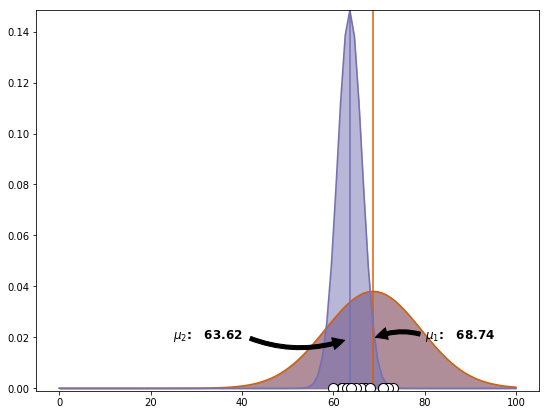

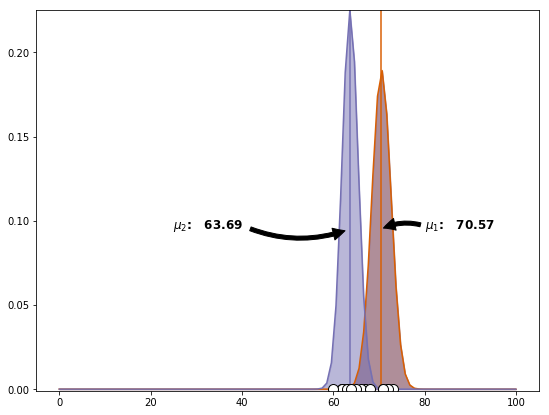

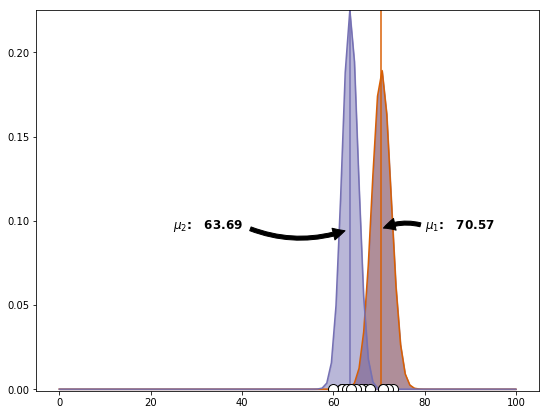

In [5]:
height = data['Height (in)']
n = len(height)

# Ground truthish
_mus = np.array([[0, data.groupby('Gender').mean().iat[0, 0]], 
                 [data.groupby('Gender').mean().iat[1, 0], 0]])
_sigmas = np.array([[[5, 0], [0, 5]], 
                    [[5, 0],[0, 5]]])
_pis = np.array([0.5, 0.5]) # priors

# initial random guesses for parameters
np.random.seed(0)

pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2) * height.std()

# generate our noisy x values
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n))
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)])

ll, pis, mus, sigmas = em_gmm_orig(xs, pis, mus, sigmas)

# In the below plots the white dots represent the observed heights.

$$\rho(x_{i}, x_{i}') = \big(\sum_{i}^{N}\mid x_{i} - x_{i}'\mid^{p}\big)^{1/p}$$